In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [ ]:
X = np.load('sample_data/cluster_prop.npy')
y = np.load('sample_data/detection_LEGUS.npy')

In [ ]:
X_ = np.zeros(np.shape(X))
X_[:,0] = np.log10(X[:,0])
X_[:,1] = np.log10(X[:,1])
X_[:,2:] = X[:,2:] + 29.98

In [ ]:
# Assume X has 6 features: 3 physical + 3 photometric
y = torch.tensor(y, dtype=torch.float32)  # Binary target (1 or 0)

y

tensor([0., 1., 0.,  ..., 0., 1., 0.])

In [ ]:
X = torch.tensor(X_, dtype=torch.float32)  # Select 5 input features

In [ ]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.2, random_state=42)

# Normalize features for stable training
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_valid = torch.tensor(scaler.transform(X_valid), dtype=torch.float32)

# Define Neural Network Model
class StarClusterNN(nn.Module):
    def __init__(self, input_size):
        super(StarClusterNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # First hidden layer
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout to prevent overfitting

            nn.Linear(32, 16),  # Second hidden layer
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(16, 8),  # Third hidden layer
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Linear(8, 1),  # Output layer (binary classification)
            nn.Sigmoid()  # Sigmoid activation for probability output
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_size = X_train.shape[1]  # Should be 6 features
model = StarClusterNN(input_size)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
batch_size = 32
X_train_batches = X_train.split(batch_size)
y_train_batches = y_train.split(batch_size)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss/len(X_train_batches):.4f}")

# Evaluate Model
model.eval()
with torch.no_grad():
    y_pred = model(X_valid).squeeze()
    y_pred_labels = (y_pred >= 0.5).float()
    accuracy = (y_pred_labels == y_valid).float().mean().item()

print(f"Validation Accuracy: {accuracy:.4f}")


Epoch [0/100], Loss: 0.7854
Epoch [10/100], Loss: 0.6944
Epoch [20/100], Loss: 0.6934
Epoch [30/100], Loss: 0.6932
Epoch [40/100], Loss: 0.6932
Epoch [50/100], Loss: 0.6932
Epoch [60/100], Loss: 0.6932
Epoch [70/100], Loss: 0.6932
Epoch [80/100], Loss: 0.6931
Epoch [90/100], Loss: 0.6931
Validation Accuracy: 0.7160


In [ ]:
from sklearn.metrics import log_loss

# Ensure model is in evaluation mode
model.eval()

# Disable gradient calculations for evaluation
with torch.no_grad():
    y_nn_pred_proba = model(X_valid).squeeze().numpy()  # Get probability predictions
    y_nn_pred = (y_nn_pred_proba >= 0.5).astype(int)  # Convert to 0/1 labels

# Compute Neural Network log loss
nn_logloss = log_loss(y_valid.numpy(), y_nn_pred_proba)

print(f"Neural Network Log Loss: {nn_logloss:.4f}")


Neural Network Log Loss: 4.5276


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import torch

# Ensure model is in evaluation mode
model.eval()

# Get the neural network's raw probability outputs
with torch.no_grad():
    y_nn_pred_proba = model(X_valid).squeeze().numpy()  # Predicted probabilities from NN

# Train a logistic regression model (Platt Scaling) on NN outputs
platt_model = LogisticRegression()
platt_model.fit(y_nn_pred_proba.reshape(-1, 1), y_valid.numpy())

# Get new calibrated probabilities
y_calibrated_proba = platt_model.predict_proba(y_nn_pred_proba.reshape(-1, 1))[:, 1]

# Compute new log loss
calibrated_logloss = log_loss(y_valid.numpy(), y_calibrated_proba)

print(f"Neural Network Log Loss (Before Calibration): {log_loss(y_valid.numpy(), y_nn_pred_proba):.4f}")
print(f"Calibrated Neural Network Log Loss (After Platt Scaling): {calibrated_logloss:.4f}")


Neural Network Log Loss (Before Calibration): 3.6668
Calibrated Neural Network Log Loss (After Platt Scaling): 0.5967


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, log_loss
import torch

# Step 1: Prepare data
X_train_np = X_train.numpy()  # Convert torch tensors to NumPy for sklearn
X_valid_np = X_valid.numpy()
y_train_np = y_train.numpy()
y_valid_np = y_valid.numpy()

# Step 2: Train a Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent")  # Always predicts majority class
dummy.fit(X_train_np, y_train_np)

# Dummy predictions
y_dummy_pred = dummy.predict(X_valid_np)
y_dummy_proba = dummy.predict_proba(X_valid_np)[:, 1]

# Step 3: Evaluate the Dummy Classifier
dummy_acc = accuracy_score(y_valid_np, y_dummy_pred)
dummy_logloss = log_loss(y_valid_np, y_dummy_proba)

print(f"Dummy Classifier Accuracy: {dummy_acc:.4f}")
print(f"Dummy Classifier Log Loss: {dummy_logloss:.4f}")

# Step 4: Evaluate the Neural Network

Dummy Classifier Accuracy: 0.7160
Dummy Classifier Log Loss: 10.2364


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import numpy as np

# 📌 Define the Improved Neural Network Model
class StarClusterNN(nn.Module):
    def __init__(self, input_size_phys, input_size_photo):
        super(StarClusterNN, self).__init__()

        # 🔹 Physical Feature Network (log(mass), log(age), mass/age ratio)
        self.phys_net = nn.Sequential(
            nn.Linear(input_size_phys, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )

        # 🔹 Photometric Feature Network (PCA-reduced magnitudes)
        self.photo_net = nn.Sequential(
            nn.Linear(input_size_photo, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )

        # 🔹 Fully Connected Layer to Merge Both Networks
        self.fc = nn.Sequential(
            nn.Linear(8 + 8, 16),  # Merge outputs from both sub-networks
            nn.ReLU(),
            nn.Linear(16, 1)  # Final binary classification output
        )

    def forward(self, x_phys, x_photo):
        x_phys_out = self.phys_net(x_phys)  # Process mass/age features
        x_photo_out = self.photo_net(x_photo)  # Process photometry features
        x_combined = torch.cat((x_phys_out, x_photo_out), dim=1)  # Merge two pathways
        return self.fc(x_combined).squeeze()

# 📌 Function to Preprocess Data
def preprocess_data(X):
    # Extract physical and photometric features
    X_phys = X[:, :2]  # First two columns (log(mass), log(age))
    X_photo = X[:, 2:]  # Last four columns (magnitudes in different bands)

    # 🔹 Feature Engineering: Compute mass/age ratio
    mass_age_ratio = (10 ** X[:, 0]) / (10 ** X[:, 1] + 1e-6)  # Avoid divide-by-zero
    X_phys = np.column_stack((X_phys, mass_age_ratio))  # Add mass/age as a new feature

    # 🔹 Apply PCA to photometry to reduce correlation
    pca = PCA(n_components=2)  # Keep 2 principal components
    X_photo_pca = pca.fit_transform(X_photo)

    return torch.tensor(X_phys, dtype=torch.float32), torch.tensor(X_photo_pca, dtype=torch.float32)

# 📌 Define Model, Optimizer, and Loss Function
input_size_phys = 3  # (log(mass), log(age), mass/age ratio)
input_size_photo = 2  # 2 PCA components

model = StarClusterNN(input_size_phys, input_size_photo)

# Use BCEWithLogitsLoss for stability
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L1 Regularization

# 🚀 Model is Ready to Train!


In [ ]:
import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import math

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# Load .fits in V as an example
v_fits = 'sample_data/hlsp_legus_hst_acs_ngc628-c_f555w_v1_drc.fits'
def load_fits_image(fits_path):
    hdul = fits.open(fits_path)
    image_data = hdul[0].data  # Extract image data
    hdul.close()
    return image_data
filename = get_pkg_data_filename(v_fits)

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

In [ ]:
import numpy as np
import os.path as osp
from astropy.io import ascii as asc
import os
import re
import glob
class catalog_reader(object):
    """
    This is a class whose job is to read observational catalogs. It is
    a purely abstract class that defines the minimum set entires that
    the read function must return
    """
    def __init__(self):
        """
        The initializer does nothing
        """
        pass

    def read(self, fname):
        """
        Function to read a catalog

        Parameters
           fname : string
              name of the catalog file to read

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
        """
        raise NotImplementedError(
            "completeness is an abstract class; "
            "implement a derived class")


class catalog_reader_rOGC(catalog_reader):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    def __init__(self):
        __doc__ == catalog_reader.__init__.__doc__

    def read(self, fname, classcut=[0, 3.5]):
        """
        Function to read a catalog from LEGUS

        Parameters
           fname : string
              name of the catalog file to read; there must be an
              accompanying metadata file, with the same base name and
              the extension .dat, in the same directory; see below
           classcut : listlike (2)
              range of LEGUS classes to include in the returned catalog

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
                 ra = array(ncluster) of cluster right ascensions
                 dec = array(ncluster) of cluster declinations
                 viscat = bool, True if this is a visually-inspected
                          catalog, false if it is an automated one
                 phot_tab = array(N) of apparent magnitudes at
                                 which the completeness has been
                                 measured
                 comp_tab = array(N, nfilter) of recovery fractions
                            for clusters of that magnitude in each
                            filter

        Notes
           The metadata file format is as follows. The 1st non-comment
           line contains the distance modulus to the target. Lines 2 -
           6 give the names of each filter used in the data
           file. Line 7 is either "visual" for a visually-inspected
           catalog or "auto" for an automatic catalog. Lines 8 to the
           end give the estimated observational completeness; on each
           line the first number is the apparent magnitude, and the
           remaining numbers are the recovery fractions for clusters
           of that apparent magnitude in the each filter.
        """

        # Read the metadata; this lists the distance modulus, filters,
        # construction method (visual or automated), and artifical
        # star test results for the file
        # fmeta = osp.splitext(fname)[0]+'.tab'
        # fp = open(fmeta, 'r')
        # metadata = fp.read().splitlines()
        # fp.close()
        # Extract data
        dmod = 29.98 # Calzetti et al 2015
        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
        else :
            print('No filters')
        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        age = np.array(data['col17'], dtype='float')
        age_max = np.array(data['col18'], dtype='float')
        age_min = np.array(data['col19'], dtype='float')

        mass = np.array(data['col20'], dtype='float')
        mass_max = np.array(data['col21'], dtype='float')
        mass_min = np.array(data['col22'], dtype='float')

        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)
        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+6)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+7)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+6)]< 99.999,data['col{:d}'.format(2*i+6)] != 66.666) # Flag value
        ra = np.array(data['col4'])
        dec = np.array(data['col5'])
        classification = np.array(data['col34'], dtype='int')

        #excluding class zero clusters from legus and potential OGCs using V-I and U-B colors
        # OGC_ = np.logical_and(np.logical_and(phot[:,-4]-phot[:,-3] > -0.7,\
        #                                                  phot[:,-4]-phot[:,-3] < 1.2), \
        #                                   np.logical_and(phot[:,-2]-phot[:,-1] > 0.95, \
        #                                                  phot[:,-2]-phot[:,-1] < 1.7))
        # OGC_b = [not bool_val for bool_val in OGC_]

        # print('Checking the boolean lists have equal shapes:',np.shape(OGC_b) == np.shape(OGC_))
        i_nocut = np.logical_and(classification > classcut[0],
                             classification < classcut[1])
        i = np.logical_and(np.logical_and(classification > classcut[0],
                             classification < classcut[1]), \
                             phot[:,-2]-phot[:,-1] <= 0.95)
        # cid_nocut = cid[i_nocut]
        cid = cid[i]
        # save a index list of non-OGC box for later use.
        # ind_OGC = []
        # subarr = list(cid)
        # arr = list(cid_nocut)

        # for i in range(len(subarr)):
        #     ind_OGC.append(arr.index(subarr[i]))
        # ind_OGC = np.array(ind_OGC)
        phot = phot[i]
        photerr = photerr[i]
        detect = detect[i]
        ra = ra[i]
        dec = dec[i]
        cla = classification[i]
        age = age[i]
        age_min = age_min[i]
        age_max = age_max[i]

        mass = mass[i]
        mass_min = mass_min[i]
        mass_max = mass_max[i]



        # Package the output
        out = { "path"       : fname,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat,
            "age"         : age,
            "age_min"     : age_min,
            "age_max"     : age_max,
            "mass"        : mass,
            "mass_min"     : mass_min,
            "mass_max"     : mass_max
            # "index_OGC" : ind_OGC
        }

        # Return
        return out

class catalog_reader_LEGUS_div(catalog_reader):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    def __init__(self):
        __doc__ == catalog_reader.__init__.__doc__

    def read(self, fname, classcut=[0, 3.5]):
        """
        Function to read a catalog from LEGUS

        Parameters
           fname : string
              name of the catalog file to read; there must be an
              accompanying metadata file, with the same base name and
              the extension .dat, in the same directory; see below
           classcut : listlike (2)
              range of LEGUS classes to include in the returned catalog

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
                 ra = array(ncluster) of cluster right ascensions
                 dec = array(ncluster) of cluster declinations
                 viscat = bool, True if this is a visually-inspected
                          catalog, false if it is an automated one
                 phot_tab = array(N) of apparent magnitudes at
                                 which the completeness has been
                                 measured
                 comp_tab = array(N, nfilter) of recovery fractions
                            for clusters of that magnitude in each
                            filter

        Notes
           The metadata file format is as follows. The 1st non-comment
           line contains the distance modulus to the target. Lines 2 -
           6 give the names of each filter used in the data
           file. Line 7 is either "visual" for a visually-inspected
           catalog or "auto" for an automatic catalog. Lines 8 to the
           end give the estimated observational completeness; on each
           line the first number is the apparent magnitude, and the
           remaining numbers are the recovery fractions for clusters
           of that apparent magnitude in the each filter.
        """

        # Read the metadata; this lists the distance modulus, filters,
        # construction method (visual or automated), and artifical
        # star test results for the file
        fmeta = osp.splitext(fname)[0]+'.tab'
        fp = open(fmeta, 'r')
        metadata = fp.read().splitlines()
        fp.close()
        # Extract data
        dmod = 29.98 # Calzetti et al 2015
        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
        else :
            print('No filters')
        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)
        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+6)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+7)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+6)]< 99.999,data['col{:d}'.format(2*i+6)] != 66.666) # Flag value
        ra = np.array(data['col4'])
        dec = np.array(data['col5'])
        classification = data['col34']



        #excluding class zero clusters from legus
        i = np.logical_and(classification > classcut[0],
                             classification < classcut[1])
        cid = cid[i]
        phot = phot[i]
        photerr = photerr[i]
        detect = detect[i]
        ra = ra[i]
        dec = dec[i]

        # Package the output
        out = { "path"       : fname,
            "basename"   : osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
             "viscat"     : viscat
        }

        # Return
        return out

class catalog_reader_LEGUS(object):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    # def __init__(self):
    #     __doc__ == catalog_reader.__init__.__doc__

    def read(self, fname, galname):

        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
            dmod = 29.98 # Calzetti et al 2015
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
            dmod = 29.98 # Calzetti et al 2015
        else :
            gallname =   galname.split('_')[0]
            galaxies = np.load('/g/data/jh2/jt4478/make_LEGUS_CCT/galaxy_names.npy')
            gal_filters = np.load('/g/data/jh2/jt4478/make_LEGUS_CCT/galaxy_filter_dict.npy', allow_pickle=True).item()
            filters = []
            for filt, cam in zip(gal_filters[gallname][0], gal_filters[gallname][1]):
                filt = filt.upper()
                cam = cam.upper()
                if cam == 'WFC3':
                    cam = 'WFC3_UVIS'
                filt_string = f'{cam}_{filt}'
                filters.append(filt_string)
            filters.sort(key=lambda x: x[-4:])
            print(f" filters are {filters}")
            gal_name = galname
            galdir = os.path.join('/g/data/jh2/jt4478/make_LEGUS_CCT', gal_name)
            # try:
            #     readme_file = os.path.join(galdir,'automatic_catalog_ngc5194-ngc5195-mosaic.readme')
            # except:
            readmes = glob.glob(f'{galdir}/automatic_catalog*{gallname}.readme')
            readme_file = readmes[0]
            with open(readme_file, "r") as f:
                content = f.read()
            # Use regular expression to extract the magnitude value
            magnitude_match = re.search(r'(\d+\.\d+) mag', content)
            if magnitude_match:
                dmod = float(magnitude_match.group(1))
                print("Magnitude Value:", dmod)
            else:
                print("Magnitude not found in the text.")


        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        try:
            age = np.array(data['col17'], dtype='float')
            age_max = np.array(data['col18'], dtype='float')
            age_min = np.array(data['col19'], dtype='float')

            mass = np.array(data['col20'], dtype='float')
            mass_max = np.array(data['col21'], dtype='float')
            mass_min = np.array(data['col22'], dtype='float')
        except:
            None

        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)


        first_mag_index = None
        class_id = None
        if not '628' in fname:
            readme_cluster_file = fname.replace(".tab", ".readme")
            with open(readme_cluster_file, 'r') as f:
                lines = f.readlines()
        else:
            readme_cluster_file = '/home/100/jt4478/slugfiles/LEGUS_cat/ngc628.readme'
            with open(readme_cluster_file, 'r') as f:
                lines = f.readlines()


        # Iterate through the lines to find the line containing "final total mag in"
        for line in lines:
            if "final total mag in" in line:
                # Extract the number before "final total mag in" using split and strip
                first_mag_index = line.split("final total mag in")[0].strip()
                first_mag_index = int(first_mag_index.rstrip('.'))
                break
        readme_cluster_file = fname.replace(".tab", ".readme")


        for line in lines:
            if "Final assigned class of the source after visual inspection" in line:
                # Extract the number before "final total mag in" using split and strip
                class_id = line.split("Final assigned class of the source after visual inspection")[0].strip()
                class_id = int(class_id.rstrip('.'))
                print(class_id)
                break
            elif "Visual classification done by LEGUS team-member Sean Linden and Brad Whitmore." in line:
                class_id = line.split("Visual classification done by LEGUS team-member Sean Linden and Brad Whitmore.")[0].strip()
                class_id = int(class_id.split('.')[0])
                print(class_id)
            elif "Final morphological classification assigned by 1 human who has verified the ML classification" in line:
                class_id = line.split("Final morphological classification assigned by 1 human who has verified the ML classification")[0].strip()
                class_id = int(class_id.split('.')[0])
                print(class_id)
            elif "Visual classification done by " in line:
                class_id = line.split("Visual classification done by ")[0].strip()
                class_id = int(class_id.split('.')[0])
                print(class_id)
            else:
                continue

        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+first_mag_index)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+first_mag_index+1)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+first_mag_index)]< 99.999, data['col{:d}'.format(2*i+first_mag_index)] != 66.666) # Flag value
        for line in lines:
            if "RA coordinates in" in line:
                # Extract the number before "final total mag in" using split and strip
                ra_d = line.split("RA coordinates in")[0].strip()
                ra_d = int(ra_d.rstrip('.'))
                break

        ra = np.array(data['col{:d}'.format(ra_d)], dtype= 'float')
        dec = np.array(data['col{:d}'.format(ra_d+1)], dtype= 'float')
        classification = np.array(data['col{:d}'.format(class_id)], dtype='int')
        classcut= [0, 3.5]
        try:
            #excluding class zero clusters from legus
            i = np.logical_and(classification > classcut[0],  classification < classcut[1])
            cid = cid[i]
            phot = phot[i]
            photerr = photerr[i]
            detect = detect[i]
            ra = ra[i]
            dec = dec[i]
            cla = classification[i]
            age = age[i]
            age_min = age_min[i]
            age_max = age_max[i]

            mass = mass[i]
            mass_min = mass_min[i]
            mass_max = mass_max[i]

             # Package the output
            output = { "path"       : fname,
            "galaxy"     :gal_name,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat,
            "age"         : age,
            "age_min"     : age_min,
            "age_max"     : age_max,
            "mass"        : mass,
            "mass_min"     : mass_min,
            "mass_max"     : mass_max}
        except:
            #excluding class zero clusters from legus
            i = np.logical_and(classification > classcut[0],  classification < classcut[1])
            cid = cid[i]
            phot = phot[i]
            photerr = photerr[i]
            detect = detect[i]
            ra = ra[i]
            dec = dec[i]
            cla = classification[i]

             # Package the output
            output = { "path"       : fname,
            "galaxy"     :gal_name,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat}


        # Return
        return output

class catalog_reader_LEGUS_good_phot(catalog_reader):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    def __init__(self):
        __doc__ == catalog_reader.__init__.__doc__
    def read(self, fname):
        """
        Function to read a catalog from LEGUS

        Parameters
           fname : string
              name of the catalog file to read; there must be an
              accompanying metadata file, with the same base name and
              the extension .dat, in the same directory; see below
           classcut : listlike (2)
              range of LEGUS classes to include in the returned catalog

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
                 ra = array(ncluster) of cluster right ascensions
                 dec = array(ncluster) of cluster declinations
                 viscat = bool, True if this is a visually-inspected
                          catalog, false if it is an automated one
                 phot_tab = array(N) of apparent magnitudes at
                                 which the completeness has been
                                 measured
                 comp_tab = array(N, nfilter) of recovery fractions
                            for clusters of that magnitude in each
                            filter

        Notes
           The metadata file format is as follows. The 1st non-comment
           line contains the distance modulus to the target. Lines 2 -
           6 give the names of each filter used in the data
           file. Line 7 is either "visual" for a visually-inspected
           catalog or "auto" for an automatic catalog. Lines 8 to the
           end give the estimated observational completeness; on each
           line the first number is the apparent magnitude, and the
           remaining numbers are the recovery fractions for clusters
           of that apparent magnitude in the each filter.
        """

        # Read the metadata; this lists the distance modulus, filters,
        # construction method (visual or automated), and artifical
        # star test results for the file
        # fmeta = osp.splitext(fname)[0]+'.tab'
        # fp = open(fmeta, 'r')
        # metadata = fp.read().splitlines()
        # fp.close()
        # Extract data
        dmod = 29.98 # Calzetti et al 2015
        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
        else :
            print('No filters')
        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        age = np.array(data['col17'], dtype='float')
        age_max = np.array(data['col18'], dtype='float')
        age_min = np.array(data['col19'], dtype='float')

        mass = np.array(data['col20'], dtype='float')
        mass_max = np.array(data['col21'], dtype='float')
        mass_min = np.array(data['col22'], dtype='float')

        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)
        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+6)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+7)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+7)] <=0.3, np.logical_and(data['col{:d}'.format(2*i+6)]< 99.999,data['col{:d}'.format(2*i+6)] != 66.666)) # Flag value
        ra = np.array(data['col4'])
        dec = np.array(data['col5'])
        classification = np.array(data['col34'], dtype='int')

        classcut=[0, 3.5]
        #excluding class zero clusters from legus
        i = np.logical_and(classification > classcut[0],
                             classification < classcut[1])
        cid = cid[i]
        phot = phot[i]
        photerr = photerr[i]
        detect = detect[i]
        ra = ra[i]
        dec = dec[i]
        cla = classification[i]
        age = age[i]
        age_min = age_min[i]
        age_max = age_max[i]

        mass = mass[i]
        mass_min = mass_min[i]
        mass_max = mass_max[i]



        # Package the output
        out = { "path"       : fname,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat,
            "age"         : age,
            "age_min"     : age_min,
            "age_max"     : age_max,
            "mass"        : mass,
            "mass_min"     : mass_min,
            "mass_max"     : mass_max
        }

        # Return
        return out

class catalog_reader_simple(catalog_reader):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    def __init__(self):
        __doc__ == catalog_reader.__init__.__doc__
    def read(self, fname, classcut=[0, 3.5]):
        """
        Function to read a catalog from LEGUS

        Parameters
           fname : string
              name of the catalog file to read; there must be an
              accompanying metadata file, with the same base name and
              the extension .dat, in the same directory; see below
           classcut : listlike (2)
              range of LEGUS classes to include in the returned catalog

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
                 ra = array(ncluster) of cluster right ascensions
                 dec = array(ncluster) of cluster declinations
                 viscat = bool, True if this is a visually-inspected
                          catalog, false if it is an automated one
                 phot_tab = array(N) of apparent magnitudes at
                                 which the completeness has been
                                 measured
                 comp_tab = array(N, nfilter) of recovery fractions
                            for clusters of that magnitude in each
                            filter

        Notes
           The metadata file format is as follows. The 1st non-comment
           line contains the distance modulus to the target. Lines 2 -
           6 give the names of each filter used in the data
           file. Line 7 is either "visual" for a visually-inspected
           catalog or "auto" for an automatic catalog. Lines 8 to the
           end give the estimated observational completeness; on each
           line the first number is the apparent magnitude, and the
           remaining numbers are the recovery fractions for clusters
           of that apparent magnitude in the each filter.
        """

        # Read the metadata; this lists the distance modulus, filters,
        # construction method (visual or automated), and artifical
        # star test results for the file
        # fmeta = osp.splitext(fname)[0]+'.tab'
        # fp = open(fmeta, 'r')
        # metadata = fp.read().splitlines()
        # fp.close()
        # Extract data
        dmod = 29.98 # Calzetti et al 2015
        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
        else :
            print('No filters')
        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        age = np.array(data['col17'], dtype='float')
        age_max = np.array(data['col18'], dtype='float')
        age_min = np.array(data['col19'], dtype='float')

        mass = np.array(data['col20'], dtype='float')
        mass_max = np.array(data['col21'], dtype='float')
        mass_min = np.array(data['col22'], dtype='float')

        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)
        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+6)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+7)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+6)]< 99.999,data['col{:d}'.format(2*i+6)] != 66.666) # Flag value
        ra = np.array(data['col4'])
        dec = np.array(data['col5'])
        classification = np.array(data['col34'], dtype='int')


        #excluding class zero clusters from legus
        i = np.logical_and(classification > classcut[0],
                             classification < classcut[1])
        cid = cid[i]
        phot = phot[i]
        photerr = photerr[i]
        detect = detect[i]
        ra = ra[i]
        dec = dec[i]
        cla = classification[i]
        age = age[i]
        age_min = age_min[i]
        age_max = age_max[i]

        mass = mass[i]
        mass_min = mass_min[i]
        mass_max = mass_max[i]



        # Package the output
        out = { "path"       : fname,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat,
            "age"         : age,
            "age_min"     : age_min,
            "age_max"     : age_max,
            "mass"        : mass,
            "mass_min"     : mass_min,
            "mass_max"     : mass_max
        }

        # Return
        return out

class catalog_reader_cl12(catalog_reader):
    """
    This is a specialization of the catalog_reader class to the format
    of the test mock catalogs.
    """
    def __init__(self):
        __doc__ == catalog_reader.__init__.__doc__
    def read(self, fname, classcut=[0, 2.5]):
        """
        Function to read a catalog from LEGUS

        Parameters
           fname : string
              name of the catalog file to read; there must be an
              accompanying metadata file, with the same base name and
              the extension .dat, in the same directory; see below
           classcut : listlike (2)
              range of LEGUS classes to include in the returned catalog

        Returns
           cat : dict
              a dict containing the data from the catalog; the returned
              data are as follows:
                 path = full path to catalog file
                 basename = base name of catalog with extensions removed
                 cid = array(ncluster), array of cluster ID numbers
                 phot = (ncluster, nfilter) array of photometric values
                 photerr = array of photometric errors; same shape as phot
                 detect = array of bool indicating whether the photometric
                          value listed represents a detection or a
                          non-detection in that band
                 filters = list of filter names
                 ra = array(ncluster) of cluster right ascensions
                 dec = array(ncluster) of cluster declinations
                 viscat = bool, True if this is a visually-inspected
                          catalog, false if it is an automated one
                 phot_tab = array(N) of apparent magnitudes at
                                 which the completeness has been
                                 measured
                 comp_tab = array(N, nfilter) of recovery fractions
                            for clusters of that magnitude in each
                            filter

        Notes
           The metadata file format is as follows. The 1st non-comment
           line contains the distance modulus to the target. Lines 2 -
           6 give the names of each filter used in the data
           file. Line 7 is either "visual" for a visually-inspected
           catalog or "auto" for an automatic catalog. Lines 8 to the
           end give the estimated observational completeness; on each
           line the first number is the apparent magnitude, and the
           remaining numbers are the recovery fractions for clusters
           of that apparent magnitude in the each filter.
        """

        # Read the metadata; this lists the distance modulus, filters,
        # construction method (visual or automated), and artifical
        # star test results for the file
        # fmeta = osp.splitext(fname)[0]+'.tab'
        # fp = open(fmeta, 'r')
        # metadata = fp.read().splitlines()
        # fp.close()
        # Extract data
        dmod = 29.98 # Calzetti et al 2015
        if '628c' in fname :
            filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'ACS_F555W', 'ACS_F814W' ]
        elif '628e' in fname :
            filters=  ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', \
                       'ACS_F435W', 'WFC3_UVIS_F555W', 'ACS_F814W' ]
        else :
            print('No filters')
        viscat = True
        data = asc.read(fname)
        cid = np.array(data['col1'], dtype='int')
        age = np.array(data['col17'], dtype='float')
        age_max = np.array(data['col18'], dtype='float')
        age_min = np.array(data['col19'], dtype='float')

        mass = np.array(data['col20'], dtype='float')
        mass_max = np.array(data['col21'], dtype='float')
        mass_min = np.array(data['col22'], dtype='float')

        nc = len(cid)
        nf = len(filters)
        phot = np.zeros((nc, nf))
        photerr = np.zeros((nc, nf))
        detect = np.ones((nc, nf), dtype=bool)
        for i in range(nf):
            phot[:,i] = data['col{:d}'.format(2*i+6)] - dmod
            photerr[:,i] = data['col{:d}'.format(2*i+7)]
            detect[:,i] = np.logical_and(data['col{:d}'.format(2*i+6)]< 99.999,data['col{:d}'.format(2*i+6)] != 66.666) # Flag value
        ra = np.array(data['col4'])
        dec = np.array(data['col5'])
        classification = np.array(data['col34'], dtype='int')


        #excluding class zero clusters from legus
        i = np.logical_and(classification > classcut[0],
                             classification < classcut[1])
        cid = cid[i]
        phot = phot[i]
        photerr = photerr[i]
        detect = detect[i]
        ra = ra[i]
        dec = dec[i]
        cla = classification[i]
        age = age[i]
        age_min = age_min[i]
        age_max = age_max[i]

        mass = mass[i]
        mass_min = mass_min[i]
        mass_max = mass_max[i]



        # Package the output
        out = { "path"       : fname,
            "basename"   :osp.splitext(osp.basename(fname))[0],
            "cid"        : cid,
            "phot"       : phot,
            "photerr"    : photerr,
            "detect"     : detect,
            "filters"    : filters,
            "dmod"       : dmod,
            "ra"         : ra,
            "dec"        : dec,
            "class"      :cla,
            "viscat"     : viscat,
            "age"         : age,
            "age_min"     : age_min,
            "age_max"     : age_max,
            "mass"        : mass,
            "mass_min"     : mass_min,
            "mass_max"     : mass_max
        }

        # Return
        return out

##############################################
# Here we register the list of known readers #
##############################################

reader_register = {
    'LEGUS' : catalog_reader_simple(),
    'LEGUS_all' : catalog_reader_LEGUS(),
    'LEGUS_div': catalog_reader_LEGUS_div(),
    'LEGUS_rOGC': catalog_reader_rOGC(),
    'LEGUS_cl12':catalog_reader_cl12(),
    'LEGUS_good_phot': catalog_reader_LEGUS_good_phot()
    }

In [ ]:
# Visualize some class 1 and 2 clusters
cat = '/ngc628c.tab'
data = reader_register['LEGUS'].read(cat)

In [ ]:
class_1 = np.where(data['class'] == 2)
ra1, dec1 = data['ra'][class_1], data['dec'][class_1]

In [ ]:
# Function to convert RA/Dec to pixel coordinates
def ra_dec_to_pixel(ra_list, dec_list, wcs):
    sky_coords = SkyCoord(ra=ra_list*u.degree, dec=dec_list*u.degree, frame='icrs')
    pixel_coords = wcs.world_to_pixel(sky_coords)
    return np.array(pixel_coords).T
# Function to load FITS file and WCS
def load_fits_with_wcs(fits_path):
    hdul = fits.open(fits_path)
    image_data = hdul[0].data  # Extract image data
    wcs = WCS(hdul[0].header)  # Extract WCS information
    hdul.close()
    return image_data, wcs

In [ ]:
# Function to extract cutouts
def extract_cutouts(image, pixel_coords, size=16):
    cutouts = []
    for (x, y) in pixel_coords:
        cutout = Cutout2D(image, (x, y), (size, size), mode='partial').data
        cutouts.append(cutout)
    return cutouts

# Function to display cutouts
def display_cutouts(cutouts):
    num_cutouts = len(cutouts)
    ncols = math.ceil(math.sqrt(num_cutouts))
    nrows = math.ceil(num_cutouts / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = np.array(axes).reshape(-1)  # Flatten in case of 2D array

    for ax, cutout in zip(axes, cutouts):
        ax.imshow(cutout, cmap='gray', origin='lower')
        ax.axis('off')

    # Hide any unused subplots
    for i in range(len(cutouts), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
fits_path = v_fits  # Replace with actual FITS file
ra_list = ra1 # Replace with actual RA values
dec_list = dec1 # Replace with actual Dec values

# Load FITS and extract WCS
image, wcs = load_fits_with_wcs(fits_path)


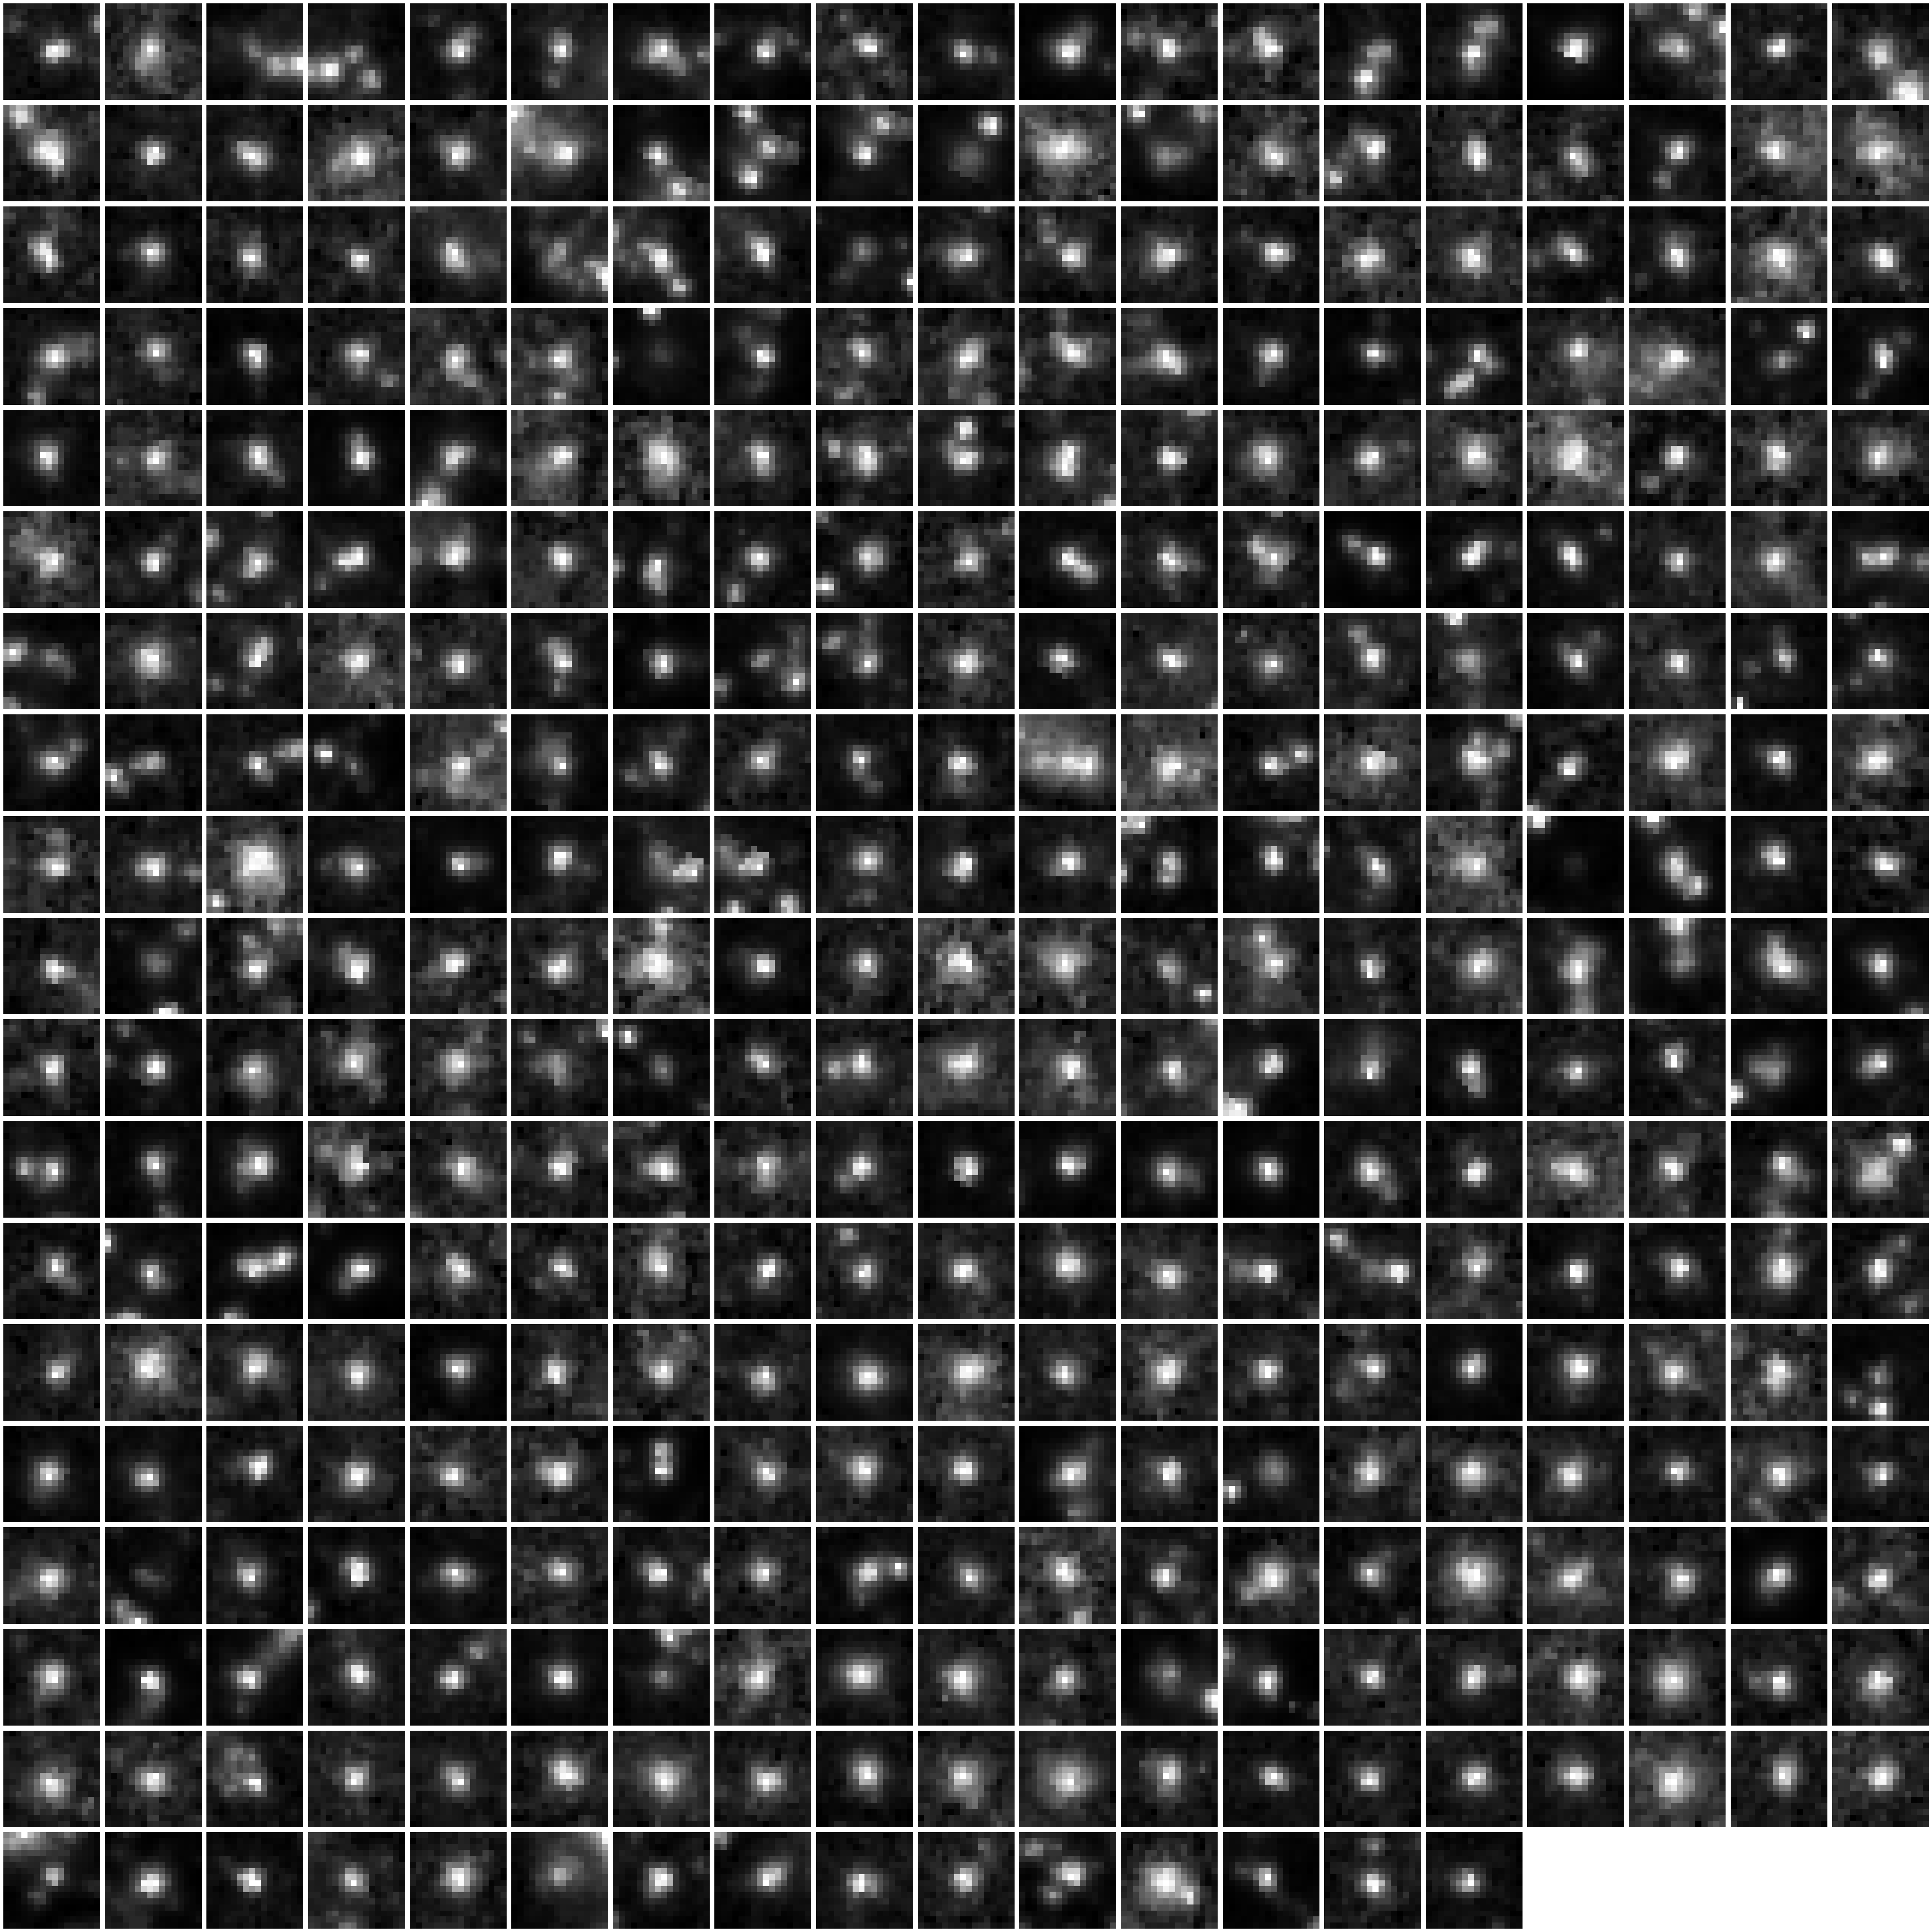

In [ ]:
# Convert RA/Dec to pixel coordinates
pixel_coords = ra_dec_to_pixel(ra_list, dec_list, wcs)

# Extract cutouts
cutouts = extract_cutouts(image, pixel_coords)

# Display the cutouts
display_cutouts(cutouts)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 🚀 Example: Create a list of 50 images (16x16)
cutouts_ = cutouts # Replace with real data

# ✅ Convert to NumPy Array with Correct Format
cutouts = np.array(cutouts_).astype(np.float32)  # Convert list to (50, 16, 16) NumPy array
cutouts = cutouts.newbyteorder('=')  # Ensure native byte order


In [ ]:
type(cutouts)

numpy.ndarray

Batch Shape: torch.Size([10, 1, 16, 16])
Original Shape: torch.Size([1, 1, 16, 16])
Noisy Shape: torch.Size([1, 1, 16, 16])
Noise Shape: torch.Size([1, 1, 16, 16])


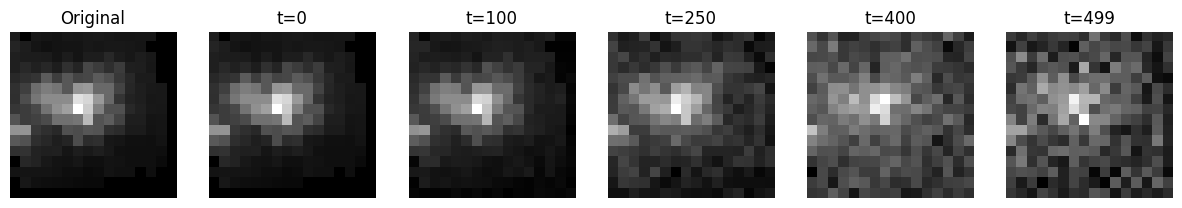

Epoch [0/100], Loss: 2.2411
Epoch [10/100], Loss: 1.9887
Epoch [20/100], Loss: 1.8792
Epoch [30/100], Loss: 1.8323
Epoch [40/100], Loss: 1.7275
Epoch [50/100], Loss: 1.7301
Epoch [60/100], Loss: 1.7426
Epoch [70/100], Loss: 1.5526
Epoch [80/100], Loss: 1.6500
Epoch [90/100], Loss: 1.5270


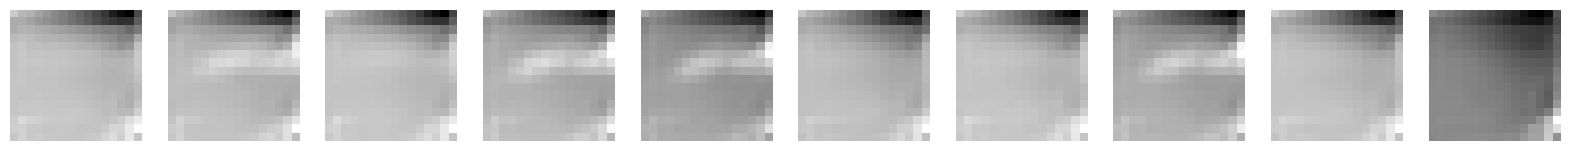

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 🚀 Load Data with Augmentation (Ensure Correct Format)
class StarClusterDataset(Dataset):
    def __init__(self, images, augment=True):
        """Dataset loader for star cluster cutouts."""
        self.images = np.array([c.astype(np.float32).newbyteorder('=') for c in images])

        self.augment = augment
        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.augment_transform = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = transforms.ToPILImage()(img)

        if self.augment:
            img = self.augment_transform(img)

        img = self.base_transform(img)
        return img

# ✅ Initialize Dataset
dataset = StarClusterDataset(cutouts, augment=True)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# ✅ Check Data Shape
for batch in dataloader:
    print("Batch Shape:", batch.shape)  # Expect (batch_size, 1, 16, 16)
    break

# 🚀 Define Diffusion Model
class DiffusionModel:
    def __init__(self, timesteps=500):
        self.timesteps = timesteps
        self.betas = torch.linspace(0.0001, 0.02, timesteps) ** 2
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x0, t):
        """Adds Gaussian noise to images."""
        noise = torch.randn_like(x0)
        t = torch.clamp(t, max=self.timesteps - 1)  # ✅ Ensure t is within range
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
        return xt, noise

# ✅ Test Diffusion
diffusion = DiffusionModel()
sample_image = next(iter(dataloader))[:1]
t = torch.randint(0, diffusion.timesteps, (1,))
xt, noise = diffusion.add_noise(sample_image, t)

# ✅ Check Shapes
print("Original Shape:", sample_image.shape)
print("Noisy Shape:", xt.shape)
print("Noise Shape:", noise.shape)

# 🚀 Visualize Diffusion Process
def visualize_diffusion(diffusion, sample_image, steps=[0, 100, 250, 400, 499]):
    fig, axes = plt.subplots(1, len(steps) + 1, figsize=(15, 3))
    axes[0].imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i, t in enumerate(steps):
        t_tensor = torch.tensor([t])
        xt, _ = diffusion.add_noise(sample_image, t_tensor)
        axes[i + 1].imshow(xt.squeeze().cpu().numpy(), cmap='gray')
        axes[i + 1].set_title(f"t={t}")
        axes[i + 1].axis("off")

    plt.show()

# ✅ Test Visualization
visualize_diffusion(diffusion, sample_image)

# 🚀 Define U-Net Model
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_emb_dim=128):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.encoder = nn.Sequential(
            nn.Conv2d(c_in, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU()
        )

        self.res_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256 + time_emb_dim, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, c_out, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t.view(-1, 1))
        t_emb = t_emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])
        x = self.encoder(x)
        x = F.relu(x + self.res_block(x))
        x = torch.cat([x, t_emb], dim=1)
        return self.decoder(x)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_diffusion(images, epochs=20, batch_size=10, lr=1e-5):
    dataset = StarClusterDataset(images, augment=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet().to(device)
    diffusion = DiffusionModel()

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()

    best_loss = float("inf")

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()

        for batch in dataloader:
            batch = batch.to(device)
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            t = torch.clamp(t, max=diffusion.timesteps - 1)  # ✅ Fix IndexError

            xt, noise = diffusion.add_noise(batch, t)
            pred_noise = model(xt, t.float() / diffusion.timesteps)

            loss = criterion(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), "best_diffusion_model.pth")

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return model, diffusion

# ✅ Train
model, diffusion = train_diffusion(cutouts, epochs=100, lr=1e-5)

# 🚀 Generate Images
def generate_images(model, diffusion, num_samples=5):
    model.eval()
    x = torch.randn((num_samples, 1, 16, 16), device=device)

    with torch.no_grad():
        for t in reversed(range(diffusion.timesteps)):
            t_tensor = torch.tensor([t] * num_samples, device=device).float() / diffusion.timesteps
            pred_noise = model(x, t_tensor)
            x = x - pred_noise

    x = x.cpu().numpy()
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(x[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_images(model, diffusion, num_samples=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 🚀 Define VAE Architecture (Encoder + Decoder)
class VAE(nn.Module):
    def __init__(self, latent_dim=8):  # Smaller latent space speeds up training
        super(VAE, self).__init__()

        # Encoder: 16x16 → Latent Space
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)  # Variance

        # Decoder: Latent Space → 16x16
        self.decoder_fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),  # 4x4 → 8x8
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()  # 8x8 → 16x16
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Sampling with reparametrization trick

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_fc(z).view(-1, 64, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

# ✅ Load & Preprocess Data
class StarClusterDataset(Dataset):
    def __init__(self, images):
        self.images = np.array([c.astype(np.float32).newbyteorder('=') for c in images])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)  # Shape: (1, 16, 16)
        return img

# ✅ Train the VAE
def train_vae(images, epochs=50, batch_size=10, latent_dim=8, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            recon, mu, logvar = model(batch)
            recon_loss = nn.functional.mse_loss(recon, batch)  # Reconstruction loss
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
            loss = recon_loss + 0.1 * kl_loss  # Balance reconstruction & KL

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return model

# ✅ Train Faster Model
vae_model = train_vae(cutouts, epochs=500, batch_size=15, latent_dim=8)

# 🚀 Generate New Star Cluster Images
def generate_vae_images(model, num_samples=5, latent_dim=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)  # Random noise in latent space
        generated = model.decoder_fc(z).view(-1, 64, 4, 4)
        generated = model.decoder(generated).cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_vae_images(vae_model, num_samples=10)


Epoch [0/500], Loss: 3.3982
Epoch [10/500], Loss: 0.7725
Epoch [20/500], Loss: 0.7460
Epoch [30/500], Loss: 0.7494
Epoch [40/500], Loss: 0.7560
Epoch [50/500], Loss: 0.7368
Epoch [60/500], Loss: 0.7167
Epoch [70/500], Loss: 0.7122
Epoch [80/500], Loss: 0.7364
Epoch [90/500], Loss: 0.7375
Epoch [100/500], Loss: 0.7243
Epoch [110/500], Loss: 0.7485
Epoch [120/500], Loss: 0.7332
Epoch [130/500], Loss: 0.7135
Epoch [140/500], Loss: 0.7684
Epoch [150/500], Loss: 0.7216
Epoch [160/500], Loss: 0.7422
Epoch [170/500], Loss: 0.7541
Epoch [180/500], Loss: 0.7164
Epoch [190/500], Loss: 0.7171
Epoch [200/500], Loss: 0.7403
Epoch [210/500], Loss: 0.7192
Epoch [220/500], Loss: 0.7387
Epoch [230/500], Loss: 0.7302
Epoch [240/500], Loss: 0.7108
Epoch [250/500], Loss: 0.7061
Epoch [260/500], Loss: 0.7447
Epoch [270/500], Loss: 0.7437
Epoch [280/500], Loss: 0.7132


KeyboardInterrupt: 

In [ ]:
generate_vae_images(vae_model, num_samples=10)

TypeError: generate_vae_images() missing 1 required positional argument: 'decoder'

In [ ]:
# 🚀 Define the Latent Diffusion Model (LDM)
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=16, timesteps=100):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps

        # Encoder: Converts (16x16) image to latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, latent_dim)
        )

        # Noise Predictor: Learns to remove noise
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder: Converts latent space back to (16x16) image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),  # 4x4 → 8x8
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()  # 8x8 → 16x16
        )

    def forward(self, x, t):
        z = self.encoder(x)  # Encode to latent space
        noise = self.noise_predictor(z)  # Predict noise
        z = z - noise * (t.view(-1, 1) / self.timesteps)  # ✅ Fix dimension mismatch
        x_recon = self.decoder(z)  # Decode back to image
        return x_recon, noise


In [ ]:
# ✅ Load & Preprocess Data
class StarClusterDataset(Dataset):
    def __init__(self, images):
        self.images = np.array([c.astype(np.float32).newbyteorder('=') for c in images])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)  # Shape: (1, 16, 16)
        return img


In [ ]:
# ✅ Train the LDM
def train_ldm(images, epochs=100, batch_size=10, latent_dim=16, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = LatentDiffusion(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            t = torch.randint(0, model.timesteps, (batch.size(0),), device=device)  # Random timestep
            x_recon, noise = model(batch, t.float())

            loss = criterion(x_recon, batch) + 0.1 * torch.mean(noise ** 2)  # Balance MSE & noise loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return model


In [ ]:
# ✅ Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Train the Model
ldm_model = train_ldm(cutouts, epochs=100, batch_size=10, latent_dim=16)


Epoch [0/100], Loss: 2.8826
Epoch [10/100], Loss: 0.6686
Epoch [20/100], Loss: 0.5909
Epoch [30/100], Loss: 0.5687
Epoch [40/100], Loss: 0.5761
Epoch [50/100], Loss: 0.5495
Epoch [60/100], Loss: 0.5459
Epoch [70/100], Loss: 0.5424
Epoch [80/100], Loss: 0.5404
Epoch [90/100], Loss: 0.5414


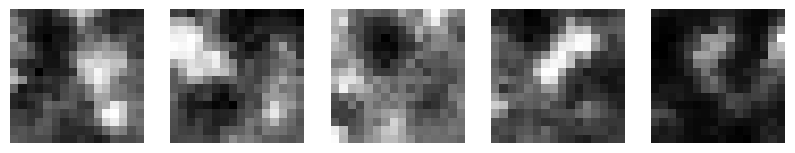

In [ ]:
# 🚀 Generate New Star Cluster Images
def generate_ldm_images(model, num_samples=5, latent_dim=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)  # Random noise in latent space
        generated = model.decoder(z).cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_ldm_images(ldm_model, num_samples=5)


In [ ]:
# 🚀 Define VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

# 🚀 Define VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()  # 8x8 → 16x16
        )

    def forward(self, z):
        x = self.fc(z)
        return self.deconv(x)


In [ ]:
# 🚀 Latent Diffusion Model (LDM)
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=16, timesteps=100):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps

        # Noise Predictor
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z, t):
        noise = self.noise_predictor(z)  # Predict noise
        z = z - noise * (t.view(-1, 1) / self.timesteps)  # Remove noise step by step
        return z, noise


In [ ]:
# 🚀 Train VAE-LDM
def train_vae_ldm(images, epochs=100, batch_size=10, latent_dim=16, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)
    diffusion = LatentDiffusion(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(diffusion.parameters()), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # Diffusion Process
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            z_denoised, noise = diffusion(z, t.float())

            # VAE Decoding
            x_recon = decoder(z_denoised)

            # Loss: Reconstruction + KL + Diffusion Noise
            recon_loss = criterion(x_recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
            noise_loss = 0.1 * torch.mean(noise ** 2)

            loss = recon_loss + kl_loss + noise_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder, diffusion


In [ ]:
# ✅ Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Train VAE-LDM Hybrid
vae_encoder, vae_decoder, ldm = train_vae_ldm(cutouts, epochs=100, batch_size=10, latent_dim=16)


Epoch [0/100], Loss: 4.3170
Epoch [10/100], Loss: 1.4626
Epoch [20/100], Loss: 1.4028
Epoch [30/100], Loss: 1.4407
Epoch [40/100], Loss: 1.3785
Epoch [50/100], Loss: 1.4121
Epoch [60/100], Loss: 1.4066
Epoch [70/100], Loss: 1.4051
Epoch [80/100], Loss: 1.4099
Epoch [90/100], Loss: 1.3939


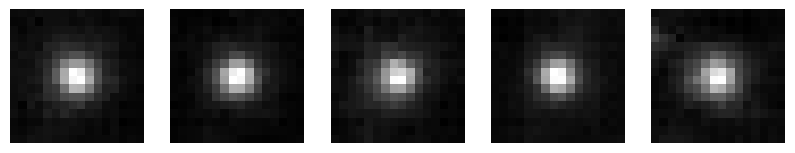

In [ ]:
# 🚀 Generate Star Clusters with VAE-LDM
def generate_vae_ldm_images(encoder, decoder, diffusion, num_samples=5, latent_dim=16):
    encoder.eval(), decoder.eval(), diffusion.eval()

    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)  # Random Latent Vectors

        # Apply Diffusion Denoising
        for t in reversed(range(diffusion.timesteps)):
            t_tensor = torch.tensor([t] * num_samples, device=device).float()
            z, _ = diffusion(z, t_tensor)

        generated = decoder(z).cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_vae_ldm_images(vae_encoder, vae_decoder, ldm, num_samples=5)


In [ ]:
# 🚀 Improved VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

# 🚀 Improved VAE Decoder with Skip Connections
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1), nn.Sigmoid()  # Extra conv for sharper details
        )

    def forward(self, z):
        x = self.fc(z)
        return self.deconv(x)
# 🚀 Improved Latent Diffusion Model (LDM)
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=32, timesteps=300):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps

        # More layers in the noise predictor
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z, t):
        noise = self.noise_predictor(z)  # Predict noise
        z = z - noise * (t.view(-1, 1) / self.timesteps)  # Remove noise step by step
        return z, noise
# 🚀 Train VAE-LDM with Perceptual Loss
def train_vae_ldm(images, epochs=200, batch_size=10, latent_dim=32, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)
    diffusion = LatentDiffusion(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(diffusion.parameters()), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # Diffusion Process
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            z_denoised, noise = diffusion(z, t.float())

            # VAE Decoding
            x_recon = decoder(z_denoised)

            # Loss: Reconstruction + KL + Diffusion Noise
            recon_loss = criterion(x_recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
            noise_loss = 0.1 * torch.mean(noise ** 2)

            loss = recon_loss + kl_loss + noise_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder, diffusion
# ✅ Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Train Improved VAE-LDM
vae_encoder, vae_decoder, ldm = train_vae_ldm(cutouts, epochs=200, batch_size=5, latent_dim=32)

In [ ]:
np.shape(cutouts)

(357, 16, 16)

In [ ]:
# 🚀 Load Data Correctly (Fix Extra Singleton Dimension)
class StarClusterDataset(Dataset):
    def __init__(self, images):
        self.images = np.array([c.astype(np.float32).newbyteorder('=') for c in images])

        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts (16,16) to (1,16,16)
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.transform(img)  # Convert to (1,16,16)
        return img  # 🔹 Do NOT use `unsqueeze(0)` to avoid extra dimension


In [ ]:
dataset = StarClusterDataset(cutouts)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

for batch in dataloader:
    print("Fixed Batch Shape:", batch.shape)  # ✅ Expect (10, 1, 16, 16)
    break


Fixed Batch Shape: torch.Size([10, 1, 16, 16])


Epoch [0/200], Loss: 45.1491
Epoch [10/200], Loss: 28.6070
Epoch [20/200], Loss: 28.5431
Epoch [30/200], Loss: 28.5401
Epoch [40/200], Loss: 28.4221
Epoch [50/200], Loss: 28.2048
Epoch [60/200], Loss: 28.0921
Epoch [70/200], Loss: 28.2984
Epoch [80/200], Loss: 28.0806
Epoch [90/200], Loss: 28.0357
Epoch [100/200], Loss: 28.1090
Epoch [110/200], Loss: 27.9841
Epoch [120/200], Loss: 28.0236
Epoch [130/200], Loss: 28.0488
Epoch [140/200], Loss: 28.1190
Epoch [150/200], Loss: 28.0191
Epoch [160/200], Loss: 27.9394
Epoch [170/200], Loss: 27.9973
Epoch [180/200], Loss: 28.0106
Epoch [190/200], Loss: 28.1456


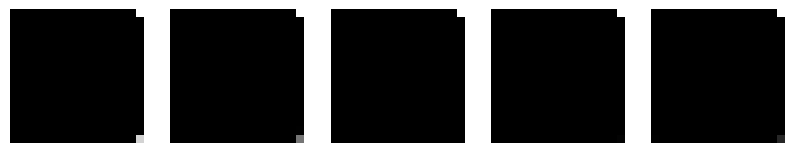

In [ ]:
# 🚀 VAE Decoder with Exact `16x16` Output
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.deconv(x)
        return x[:, :, :16, :16]  # 🔹 Ensure exact (1, 16, 16) shape

# 🚀 Latent Diffusion Model (LDM)
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=64, timesteps=300):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps
        self.time_embedding = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z, t):
        t_emb = self.time_embedding(t.view(-1, 1))  # 🔹 Ensure correct shape
        noise = self.noise_predictor(z + t_emb)
        return z - noise * (t.view(-1, 1) / self.timesteps), noise

# 🚀 Train VAE-LDM Hybrid Model
def train_vae_ldm(images, epochs=200, batch_size=10, latent_dim=64, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)
    diffusion = LatentDiffusion(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(diffusion.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar) + 1e-6  # 🔹 Prevents division by zero
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # Diffusion Process
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            z_denoised, noise = diffusion(z, t.float())

            # VAE Decoding
            x_recon = decoder(z_denoised)

            # Loss: Reconstruction + KL + Diffusion Noise
            recon_loss = criterion(x_recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            noise_loss = 0.1 * torch.mean(noise ** 2)

            loss = recon_loss + kl_loss + noise_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder, diffusion

# 🚀 Generate Star Clusters with LDM
def generate_vae_ldm_images(encoder, decoder, diffusion, num_samples=5, latent_dim=64):
    encoder.eval(), decoder.eval(), diffusion.eval()

    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)
        for t in reversed(range(diffusion.timesteps)):
            t_tensor = torch.tensor([t] * num_samples, device=device).float()
            z, _ = diffusion(z, t_tensor)

        generated = decoder(z).cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Train & Generate Star Clusters
vae_encoder, vae_decoder, ldm = train_vae_ldm(cutouts, epochs=200, batch_size=10, latent_dim=64)
generate_vae_ldm_images(vae_encoder, vae_decoder, ldm, num_samples=5)


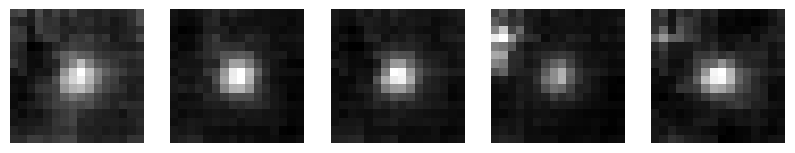

In [ ]:
# 🚀 Generate Improved Star Clusters
def generate_vae_ldm_images(encoder, decoder, diffusion, num_samples=5, latent_dim=32):
    encoder.eval(), decoder.eval(), diffusion.eval()

    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)  # Random Latent Vectors

        # Apply Diffusion Denoising
        for t in reversed(range(diffusion.timesteps)):
            t_tensor = torch.tensor([t] * num_samples, device=device).float()
            z, _ = diffusion(z, t_tensor)

        generated = decoder(z).cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_vae_ldm_images(vae_encoder, vae_decoder, ldm, num_samples=5)


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 🚀 Custom Dataset for Star Cluster Images
class StarClusterDataset(Dataset):
    def __init__(self, images):
        """
        Args:
            images (numpy.ndarray): Shape (356, 16, 16), grayscale star cluster images.
        """
        self.images = images.astype(np.float32)  # Ensure correct data type

        # Define transformation: Convert to PyTorch tensor and normalize
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts (16,16) → (1,16,16) automatically
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to (-1,1)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # (16,16)
        img = self.transform(img)  # (1,16,16)
        return img

# ✅ Create Dataset & DataLoader
dataset = StarClusterDataset(cutouts)  # cutouts is (356,16,16)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# ✅ Verify Shape
for batch in dataloader:
    print("Batch Shape:", batch.shape)  # Expect (10, 1, 16, 16)
    break


Batch Shape: torch.Size([10, 1, 16, 16])


In [ ]:
import torch.nn as nn
import torch.optim as optim

# 🚀 VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # (16x16 → 8x8)
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # (8x8 → 4x4)
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

# 🚀 VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        return self.deconv(x)


In [ ]:
# 🚀 Train VAE Model
def train_vae(images, epochs=100, batch_size=10, latent_dim=32, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    criterion = nn.MSELoss()  # Reconstruction Loss

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # VAE Decoding
            x_recon = decoder(z)

            # Loss: Reconstruction + KL Divergence
            recon_loss = criterion(x_recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

            loss = recon_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder

# ✅ Train VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_encoder, vae_decoder = train_vae(cutouts, epochs=100, batch_size=10, latent_dim=32)


Epoch [0/100], Loss: 48.5790
Epoch [10/100], Loss: 28.5844
Epoch [20/100], Loss: 28.5781
Epoch [30/100], Loss: 28.5482
Epoch [40/100], Loss: 28.5656
Epoch [50/100], Loss: 28.5871
Epoch [60/100], Loss: 28.5642
Epoch [70/100], Loss: 28.5701
Epoch [80/100], Loss: 28.5707
Epoch [90/100], Loss: 28.6583


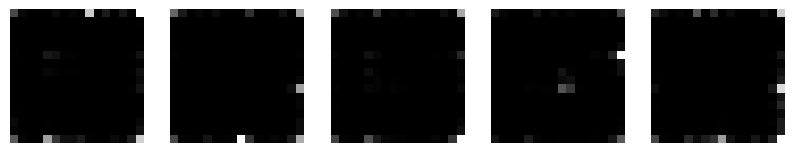

In [ ]:
import matplotlib.pyplot as plt

# 🚀 Generate New Star Clusters
def generate_vae_images(encoder, decoder, num_samples=5, latent_dim=32):
    encoder.eval(), decoder.eval()

    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim), device=device)  # Sample latent space
        generated = decoder(z).cpu().numpy()  # Convert to NumPy

    # Plot Images
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()

# ✅ Generate & Plot
generate_vae_images(vae_encoder, vae_decoder, num_samples=5)


In [ ]:

# 🚀 Improved VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

# 🚀 Improved VAE Decoder with Skip Connections
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1), nn.Sigmoid()  # Extra conv for sharper details
        )

    def forward(self, z):
        x = self.fc(z)
        return self.deconv(x)
# 🚀 Improved Latent Diffusion Model (LDM)
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=32, timesteps=300):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps

        # More layers in the noise predictor
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z, t):
        noise = self.noise_predictor(z)  # Predict noise
        z = z - noise * (t.view(-1, 1) / self.timesteps)  # Remove noise step by step
        return z, noise
# 🚀 Train VAE-LDM with Perceptual Loss
def train_vae_ldm(images, epochs=200, batch_size=10, latent_dim=32, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)
    diffusion = LatentDiffusion(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(diffusion.parameters()), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # Diffusion Process
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            z_denoised, noise = diffusion(z, t.float())

            # VAE Decoding
            x_recon = decoder(z_denoised)

            # Loss: Reconstruction + KL + Diffusion Noise
            recon_loss = criterion(x_recon, batch)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
            noise_loss = 0.1 * torch.mean(noise ** 2)

            loss = recon_loss + kl_loss + noise_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder, diffusion
# ✅ Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Train Improved VAE-LDM
vae_encoder, vae_decoder, ldm = train_vae_ldm(cutouts, epochs=200, batch_size=5, latent_dim=32)

Epoch [0/200], Loss: 7.8643
Epoch [10/200], Loss: 2.9091
Epoch [20/200], Loss: 2.8292
Epoch [30/200], Loss: 2.7913
Epoch [40/200], Loss: 2.9019
Epoch [50/200], Loss: 2.7011
Epoch [60/200], Loss: 2.5559
Epoch [70/200], Loss: 2.5402
Epoch [80/200], Loss: 2.5281
Epoch [90/200], Loss: 2.6699
Epoch [100/200], Loss: 2.4670
Epoch [110/200], Loss: 2.6076
Epoch [120/200], Loss: 2.6725
Epoch [130/200], Loss: 2.6706
Epoch [140/200], Loss: 2.5646
Epoch [150/200], Loss: 2.6039
Epoch [160/200], Loss: 2.6932
Epoch [170/200], Loss: 2.6351
Epoch [180/200], Loss: 2.8082
Epoch [190/200], Loss: 2.5775


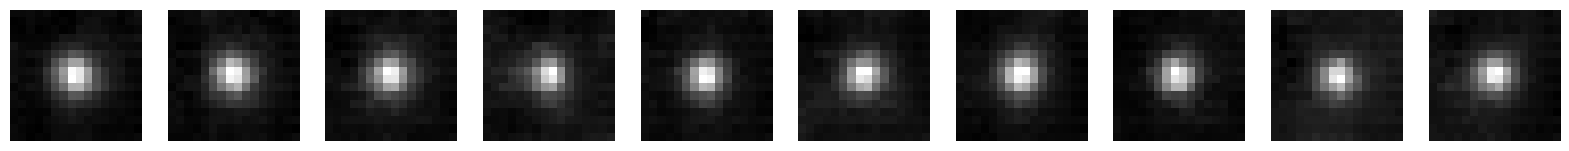

In [ ]:
generate_vae_images(vae_encoder, vae_decoder, num_samples=10)

In [ ]:
from torchvision import transforms

class StarClusterDataset(Dataset):
    def __init__(self, images, augment=True):
        """
        Dataset loader for star cluster cutouts with optional augmentations.
        """
        self.images = np.array([c.astype(np.float32).newbyteorder('=') for c in images])
        self.augment = augment

        # Basic transformation (Convert to tensor & normalize)
        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # Data Augmentations (Random Rotations & Flips)
        self.augment_transform = transforms.Compose([
            transforms.RandomRotation(degrees=45),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        # Convert to PIL for transforms
        img = transforms.ToPILImage()(img)

        # Apply augmentation if enabled
        if self.augment:
            img = self.augment_transform(img)

        # Convert back to tensor
        img = self.base_transform(img)

        return img


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), nn.ReLU(),  # 16x16 → 16x16 (Preserve details)
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 16x16 → 8x8
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),  # 8x8 → 4x4
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar


In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1), nn.Sigmoid()  # Extra conv for fine details
        )

    def forward(self, z):
        x = self.fc(z)
        return self.deconv(x)


In [ ]:
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim=32, timesteps=300):
        super(LatentDiffusion, self).__init__()
        self.timesteps = timesteps

        # Spatial attention mechanism
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.Softmax(dim=-1)  # Attention-like behavior
        )

    def forward(self, z, t):
        noise = self.noise_predictor(z)  # Predict structured noise
        z = z - noise * (t.view(-1, 1) / self.timesteps)  # Remove noise step by step
        return z, noise


In [ ]:
def train_vae_ldm(images, epochs=200, batch_size=10, latent_dim=32, lr=1e-3):
    dataset = StarClusterDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = VAEEncoder(latent_dim).to(device)
    decoder = VAEDecoder(latent_dim).to(device)
    diffusion = LatentDiffusion(latent_dim).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(diffusion.parameters()), lr=lr)

    # Perceptual Loss: Combination of L1 (for details) and MSE (for stability)
    def perceptual_loss(recon, target):
        return 0.7 * F.l1_loss(recon, target) + 0.3 * F.mse_loss(recon, target)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            # VAE Encoding
            mu, logvar = encoder(batch)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std  # Reparameterization Trick

            # Diffusion Process
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device)
            z_denoised, noise = diffusion(z, t.float())

            # VAE Decoding
            x_recon = decoder(z_denoised)

            # Loss: Perceptual + KL + Diffusion Noise
            recon_loss = perceptual_loss(x_recon, batch)
            kl_loss = -0.3 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # Lower KL weight to avoid excessive smoothing
            noise_loss = 0.05 * torch.mean(noise ** 2)  # Reduce noise penalty

            loss = recon_loss + kl_loss + noise_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

    return encoder, decoder, diffusion


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def generate_vae_ldm_images(encoder, decoder, diffusion, num_samples=5, latent_dim=64):
    encoder.eval(), decoder.eval(), diffusion.eval()

    with torch.no_grad():
        # Introduce small random jitter to latent space to encourage variations
        z = torch.randn((num_samples, latent_dim), device=device)
        jitter = torch.normal(mean=0, std=0.05, size=z.shape, device=device)  # Small Gaussian Noise
        z += jitter

        # Apply Diffusion Denoising
        for t in reversed(range(diffusion.timesteps)):
            t_tensor = torch.tensor([t] * num_samples, device=device).float()
            z, _ = diffusion(z, t_tensor)

        generated = decoder(z).cpu().numpy()

    # Plot Results
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated[i, 0], cmap='gray')
        axs[i].axis("off")
    plt.show()


# ✅ Train & Generate
vae_encoder, vae_decoder, ldm = train_vae_ldm(cutouts, epochs=200, batch_size=5, latent_dim=64)



Epoch [0/200], Loss: 68.5915
Epoch [10/200], Loss: 58.0604
Epoch [20/200], Loss: 58.1367
Epoch [30/200], Loss: 57.9825
Epoch [40/200], Loss: 57.9522
Epoch [50/200], Loss: 58.0615
Epoch [60/200], Loss: 58.1108
Epoch [70/200], Loss: 58.1585
Epoch [80/200], Loss: 58.0239
Epoch [90/200], Loss: 58.0698
Epoch [100/200], Loss: 58.0658
Epoch [110/200], Loss: 58.0225
Epoch [120/200], Loss: 58.1944
Epoch [130/200], Loss: 58.1421
Epoch [140/200], Loss: 58.1738
Epoch [150/200], Loss: 58.1466
Epoch [160/200], Loss: 58.0866
Epoch [170/200], Loss: 58.0769
Epoch [180/200], Loss: 58.1794
Epoch [190/200], Loss: 58.0567


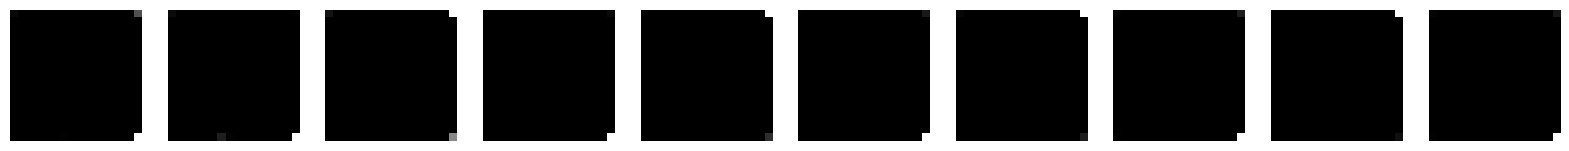

In [ ]:
generate_vae_ldm_images(vae_encoder, vae_decoder, ldm, num_samples=10)